<a href="https://colab.research.google.com/github/AchikoKatamadze/CWithClasses/blob/main/4_2_Deep_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and utilities

Install required packages, configure virtual display, define utilities for video playback.


In [3]:
!apt install -y xvfb ffmpeg swig
!pip install pyvirtualdisplay gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 swig4.0 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 swig swig4.0 x11-xkb-utils xfonts-base xfonts-encodings
  xfonts-utils xserver-common xvfb
0 upgraded, 11 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,930 kB of archives.
After this operation, 17.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64

In [4]:
from pyvirtualdisplay import Display

virtual_display = Display(visible=False, size=(800, 600))
virtual_display.start()

In [5]:
def play_video(frames, fps=30):
  from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
  from IPython.display import Video, display
  import time
  import os
  ts = time.time()
  file_name = f"temp-{ts}.mp4"
  clip = ImageSequenceClip(frames, fps)
  clip.write_videofile(file_name, logger=None)
  display(Video(file_name, embed = True))
  os.remove(file_name)

# Continuous environments

Majority of real-world problems (environments) are **not discrete** and observations are specified as continuous numbers (e.g. sensor readings) rather than discrete positions. For such environments *Q-learning* algorithm is not directly applicable and different approach is needed.

The RL idea stays the same: agent should learn optimal / adequate policy, and use it to make decisions on his actions. However, in this case the policy is implemented as **a mathematical function** with **continuous input** parameters (in contrast to `Q` table with discrete records).

One of the approaches how to *approximate unknown continuous function* are **artificial neural networks**.

# Deep Q-learning algorithm

In essence Deep Q-learning algorithm replaces Q-table with neural network:
* inputs - *continuous* state readings (e.g. from sensors);
* outputs - estimated $Q$ values (*expected reward* for each action).

However training process of such model is *not stable* because current $Q$ estimate includes max future $Q$ estimate. In other words, for training the model we need already pre-trained model (*the chicken or the egg* dilemma).

$$
Q \leftarrow r_t + \gamma
\cdot \underbrace{\max_a{Q(s_{t+1}, a)}}_\textrm{max future reward} \tag{1}
$$

## "Twin" model trick

One of the possible tricks to overcome this problem is to use **two** identical models:
 * the `main` model for predicting (and training) current $Q$ value;
 * and the `future` model for estimating the future $Q$ value.

The idea is to **occasionally** transfer training results from the `main` model to the `future` model. This way the future reward estimation is "frozen" in time and the main model gets a chance to learn useful information about the environment.



## Experience replay
Another trick used in Deep Q-learning algorithm is *experience replay*. Training neural network using only immediate state and reward (as it is done in regular Q-learning) is not very effective. The neural network very quickly *overfits*: it "remembers" only the latest episodes and "forgets" all the previous experience.

The idea is to create a dataset of historical *state-action-reward* examples. And use it to train the model in batches.

# Lunar lander environment

Let's consider following environment and an idle agent ("do nothing" is valid action in this case).

In [6]:
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="rgb_array_list")

total_reward = 0.0
initial_state, info = env.reset()

# run simulation steps
while True:
  # decision: do nothing (free fall)
  action = 0

  # step: perform the action
  state, reward, terminated, timeout, info = env.step(action)

  total_reward += reward

  if terminated or timeout:
    # exit loop if simulation stopped
    break

# render episode frames
frames = env.render()
play_video(frames)


# print some info about the episode
def print_state(x, y, vx, vy, a, va, gl, gr):
  print(f"\tPos: [{x:5.2f} {y:5.2f}]; angle: {a:5.2f}")
  print(f"\tVel: [{vx:5.2f} {vy:5.2f}]; a.vel: {va:5.2f}")
  print(f"\tGnd: [{gl == 1} {gr == 1}]")

print("Initial state")
print_state(*initial_state)

print("Final state")
print_state(*state)

print(f"Total reward: {total_reward:.2f}")

Initial state
	Pos: [ 0.01  1.41]; angle: -0.01
	Vel: [ 0.56 -0.18]; a.vel: -0.13
	Gnd: [False False]
Final state
	Pos: [ 0.37 -0.13]; angle: -0.33
	Vel: [ 1.06 -0.19]; a.vel:  0.31
	Gnd: [True True]
Total reward: -154.87


The main agent of the environment is *a lunar lander*, and its task is to perform **soft landing** on the area between the flags. The environment provides *continuous* readings from 8 different sensors, like position and velocity. The agent can perform various actions, like fire main or orientation engines. Depending on the landing peculiarities the agent gets different cumulative reward. The landing is considered successful if the agent scores **200 points** or more.

More info about the environment is available in the [documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/).

A demonstration of manually tuned heuristic landing algorithm is shown below.

In [45]:
from gymnasium.envs.box2d.lunar_lander import heuristic

state, _ = env.reset()

total_reward = 0
while True:
  action = heuristic(env, state)
  state, reward, terminated, timeout, _ = env.step(action)
  total_reward += reward

  if terminated or timeout:
    break

frames = env.render()
play_video(frames)

print(f"Total reward: {total_reward:.2f}")

Total reward: 248.01


# Task: Implement Deep Q-learning algorithm

> Note: The points below suggest to structure the algorithm as a number of separate functions. However it is not strictly necessary and the algorithm can be implemented as single block of code with nested loops and conditions. Follow your preferred style of code structuring.



## 1\. Variables and data structures

Define "twin" Q-models
  * use `tf.keras.Sequential` as a base;
  * add `Input` layer with appropriate shape;
  * add 1-2 hidden `Dense` layers with `relu` activation;
  * add output `Dense` layer with appropriate shape and `linear` activation (`Q`-value estimation is a *regression* task);
  * create two identical models, e.g. `main_model` and `future_model`;
  * show `summary` for one of them.
  * hint: use `he_uniform` kernel initializer for better stability;
  * hint: don't use `bias`;
  * hint: aim for several `thousands` of parameters.

Define `Adam` optimizer
  * use `0.001` learning rate or lower.

Create data structure for experience replay `memory`
  * during simulation steps you will store current `state`, performed `action`, obtained `reward` and `next_state` of the environment;
  * limit the size of memory to `10 000` records;
  * organize the memory according to `FIFO` approach;
  * hint: you can create dedicated storage for *each* parameter, or use one storage for *all* of them;
  * hint: `collections.deque` is a good option to use, but regular `list` will do the trick with proper handling.

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

num_actions = env.action_space.n

# "twin" models
main_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(env.observation_space.shape[0],)),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', use_bias=False),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', use_bias=False),
    tf.keras.layers.Dense(num_actions, activation='linear', kernel_initializer='he_uniform', use_bias=False)
])

future_model = tf.keras.models.clone_model(main_model)
future_model.set_weights(main_model.get_weights())

# make sure to (re)create optimizer together with models
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# it is a good idea to reset the memory if models have changed
from collections import deque
memory = deque(maxlen=10_000)

## 2\. Utility functions

Define action selection function (e.g. `make_decision`)
  * implement *Epsilon-Greedy algorithm*;
  * provide `state` and `epsilon` parameters as inputs;
  * predict `Q` values by `main_model`;
  * **NB!** the model expects *a batch* of inputs, make sure to convert `state` vector into *single-element* array of states.
  
  $$ (s_1, s_2, ..., s_n) \Rightarrow \begin{bmatrix} \\ (s_1, s_2, ..., s_n)\\ \\\end{bmatrix}$$

In [47]:
def make_decision(state, epsilon, num_actions, model):
    if np.random.rand() < epsilon:
        return np.random.choice(num_actions)

    state_batch = np.expand_dims(state, axis=0)
    q_values = model(state_batch)
    return np.argmax(q_values.numpy())


Investigate provided `train_model` function
  * it implements single training step (ref [lecture](https://docs.google.com/presentation/d/1DJvFhmJlrmUN7YF-aK60rUQLc_Vw-hlrzQ0p4OgtQfo/edit#slide=id.g2981092e36d_0_80) for details);
  * inputs are `batches` of parameters;
  * `@tf.function` annotation converts the function to highly efficient *computation graph*, but restricts some functionality (e.g. `print` won't work);
  * **NB!** The function assume certain names for variables. Modify the code to match the names of your variables if needed.

In [48]:
@tf.function
def train_model(states, actions, rewards, next_states):
  future_factor = 0.99
  future_Q_values = future_model(next_states)
  max_future_Q_values = tf.reduce_max(future_Q_values, axis=1)
  expected_Q_values = rewards + future_factor * max_future_Q_values
  action_masks = tf.one_hot(actions, num_actions)
  with tf.GradientTape() as tape:
    all_Q_values = main_model(states, training=True)
    actual_Q_values = tf.reduce_sum(all_Q_values * action_masks, axis=1)
    loss = tf.keras.losses.huber(expected_Q_values, actual_Q_values)
  grads = tape.gradient(loss, main_model.trainable_variables)
  adam.apply_gradients(zip(grads, main_model.trainable_variables))

## 3\. Simulation episode

Implement single simulation episode (e.g. create function `run_episode`)
  * `reset` the environment;
  * perform simulation steps until episode is `terminated` or `timeout`;
  * within `every` step:
    * `make_decision` of the next action;
    * perform the `action`;
    * store the results of the `step` in the experience replay `memory`;    
  * every `5th` step:
    * randomly `sample` batch of records from the `memory`;
    * use `64` records per batch;
    * convert records to `np.array` with appropriate `dtype` (use `np.int8` for `actions` and `np.float32` for other parameters);
    * `train_model` on the batch;      
    * hint: make sure there is enough records in the `memory` before sampling;
  * keep track of cumulative `total_reward` for the episode (e.g. return it as a result of function).
  * hint: use dedicated `train` environment with disabled rendering for better performance;
  * hint: lower `max_episode_steps` limit to stop *stale* simulations early (e.g. when *lander* hovers, but does not descent);

In [49]:
import random

def run_episode(env, epsilon, batch_size=64, max_steps=1000):

    state, _ = env.reset()
    total_reward = 0.0

    for step in range(max_steps):

        action = make_decision(state, epsilon, num_actions, main_model)
        next_state, reward, terminated, timeout, _ = env.step(action)
        memory.append((state, action, reward, next_state, terminated))
        total_reward += reward
        state = next_state

        if step % 5 == 0 and len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states = zip(*[
                (b[0], b[1], b[2], b[3]) for b in batch if not b[4]
            ])

            states = np.array(states, dtype=np.float32)
            actions = np.array(actions, dtype=np.int8)
            rewards = np.array(rewards, dtype=np.float32)
            next_states = np.array(next_states, dtype=np.float32)

            train_model(states, actions, rewards, next_states)

        if terminated or timeout:
            break

    return total_reward


## 4\. Training loop

Implement training loop
  * train the agent for `1 000` episodes or more;
  * `run_episode` and record `total_reward` as a training `history`;
  * **NB!** after each episode synchronize `main` and `future` models (ref `get_weights` and `set_weights` methods);
  * update `epsilon` if needed;
  * output training progress (don't "spam" 100500 lines of logs);
  * hint: start training with high *exploration* rate (e.g. `100%`), decay it to small value within `200-300` episodes (e.g. `1-3%`);  
  * hint: expect prolonged training time (~10-15 mins) due to lengthy simulations;
  * hint: stop training earlier if the agent reached good performance (e.g. if average reward for last `100` episodes is over `200` points);
  * hint: consider `saving` trained model to file in order to restore it for later tasks (and avoid lengthy training).

In [50]:
def train_agent(env, num_episodes=1000, batch_size=64, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=300):

    training_history = []
    epsilon = epsilon_start

    for episode in range(1, num_episodes + 1):

        total_reward = run_episode(env, epsilon, batch_size=batch_size)
        training_history.append(total_reward)
        epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (episode / epsilon_decay))
        future_model.set_weights(main_model.get_weights())

        if episode % 50 == 0:
            avg_reward = np.mean(training_history[-50:])
            print(f"Episode {episode}/{num_episodes} | Avg Reward (last 50): {avg_reward:.2f} | Epsilon: {epsilon:.2f}")

            if len(training_history) >= 100 and np.mean(training_history[-100:]) >= 200:
                print(f"Stopping early: Average reward for last 100 episodes is {np.mean(training_history[-100:]):.2f}")
                break

    main_model.save("lunar_lander_model.h5")
    print("Training complete. Model saved as 'lunar_lander_model.h5'.")
    return training_history


## 5\. Training results

Plot training results

  * use training `history` as a source;
  * be creative on how to show it;
  * hint: an example of `moving average` reward is shown below.

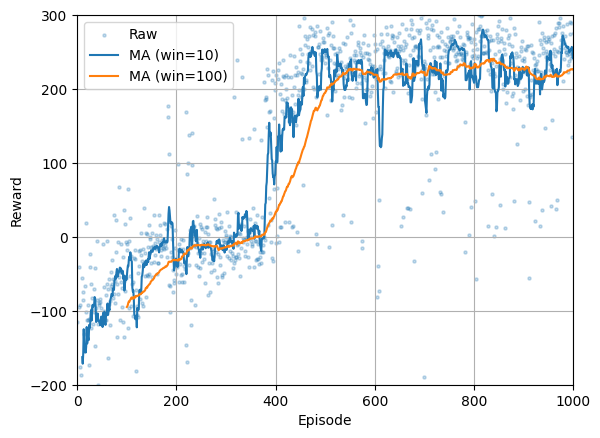

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_results(training_history, window_size=50):

    if len(training_history) == 0:
        print("Error: No training history to plot.")
        return


    moving_avg = np.convolve(training_history, np.ones(window_size)/window_size, mode='valid')


    plt.figure(figsize=(12, 6))
    plt.plot(training_history, label="Total Reward per Episode", alpha=0.5, color="blue")
    plt.plot(range(window_size - 1, len(training_history)), moving_avg, label=f"Moving Average (Window: {window_size})", color="red", linewidth=2)


    plt.axhline(y=200, color="green", linestyle="--", label="Success Threshold (200)")


    plt.title("Training Performance of the Lunar Lander Agent")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend(loc="upper left")
    plt.grid(True)


    plt.show()


training_history = train_agent(env)
plot_training_results(training_history, window_size=50)


Episode 50/1000 | Avg Reward (last 50): -138.98 | Epsilon: 0.83
Episode 100/1000 | Avg Reward (last 50): -89.41 | Epsilon: 0.67
Episode 150/1000 | Avg Reward (last 50): -72.84 | Epsilon: 0.51
Episode 200/1000 | Avg Reward (last 50): 0.95 | Epsilon: 0.34
Episode 250/1000 | Avg Reward (last 50): 4.52 | Epsilon: 0.17


KeyboardInterrupt: 

## 6\. Test the agent

Now the trained agent can be used to solve the problem: perform soft landing on the moon.

  * run `20` testing episodes;
     * `reset` the environment;
     * simulate environment `steps`
        * `make_decision` on acton and perform it;
        * be sure *exploration* is disabled;
     * record episode results;
  * output average `reward` for all testing episodes;
  * evaluate the results;
    * How well the agent is trained?
    * What can be improved?

In [ ]:
# TODO: your code goes here

## 7\. Demonstrate the agent

  * run `single` episode;
  * use environment with enabled `rendering`;
  * `play_video` of the episode;
  * print `total_reward` of the episode;
  * Did the agent landed softly?

In [ ]:
# TODO: your code goes here